# Installing pacakages

In [1]:
!pip install librosa -q

# Importing Libraries

In [10]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os

# TensorFlow

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPool1D, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Sklearn

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data

In [8]:
DATA_PATH = '/kaggle/input/patient-health-detection-using-vocal-audio'

In [6]:
os.listdir(DATA_PATH)

['patient-vocal-dataset-small', 'patient-vocal-dataset']

In [11]:
# length of the dataset-small

print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset-small/patient-vocal-dataset-small/Laryngozele')))
print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset-small/patient-vocal-dataset-small/Vox senilis')))
print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset-small/patient-vocal-dataset-small/Normal')))

29
28
28


In [12]:
# length of the actual dataset

print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset/Laryngozele')))
print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset/Vox senilis')))
print(len(os.listdir('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset/Normal')))

85
392
560


# Librosa 

In [13]:
def librosa_test(audio):
    y, sr = librosa.load(audio)
    D = librosa.stft(y)
    spectrogram = librosa.amplitude_to_db(abs(D))
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log Spectrogram')
    plt.show()

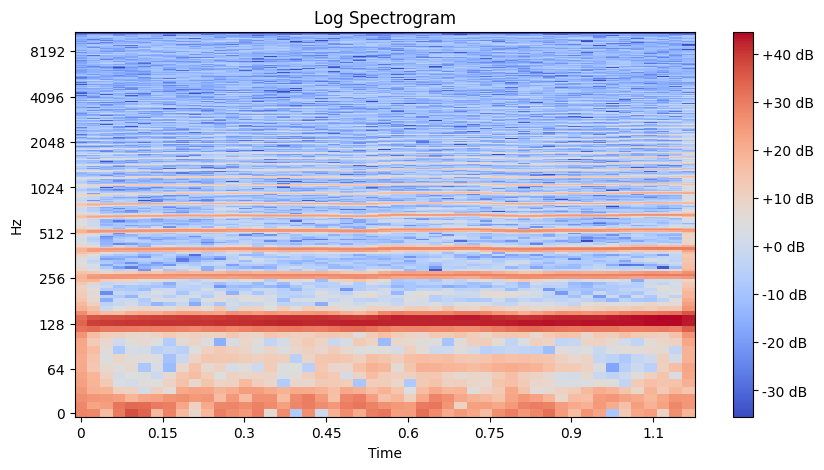

In [14]:
librosa_test('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset/Laryngozele/1205-a_h-egg.wav')

In [15]:
def audio_to_data(path):
    data = []
    label = []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            if j.endswith('.wav'):
                #print(os.path.join(path,i,j))
                y, sr = librosa.load(os.path.join(path, i, j))
                D = librosa.stft(y)
                spectrogram = librosa.amplitude_to_db(abs(D))
                spectrogram_resized = cv2.resize(spectrogram, (40, 1025))
                data.append(spectrogram_resized)
                label.append(i)
    return np.array(data), np.array(label)

In [16]:
audio, label = audio_to_data('/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset')

In [13]:
audio.shape

(1036, 1025, 40)

In [18]:
type(label)

numpy.ndarray

In [19]:
label_encoder = LabelEncoder()

label_enc = label_encoder.fit_transform(label)

In [20]:
num_classes = len(set(label))
label_train_categorical = to_categorical(label_enc, num_classes=num_classes)

In [21]:
label_train_categorical

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [22]:
audio_train, audio_test, label_train, label_test = train_test_split(audio, label_train_categorical, test_size=0.2, random_state=42)

In [23]:
type(label_train)

numpy.ndarray

In [20]:
audio_train[0].shape

(1025, 40)

# Model Building

In [25]:
# model = Sequential()

# model.add(Conv2D(16, 3, 1, activation='relu', input_shape=(1036, 1025, 40)))
# model.add(MaxPool2D())

# model.add(Conv2D(64, 3, 1, activation='relu'))
# model.add(MaxPool2D())

# model.add(Conv2D(32, 3, 1, activation='relu'))
# model.add(MaxPool2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

In [24]:
model = Sequential()

model.add(Conv1D(16, 3, 1, activation='relu', input_shape=(audio_train.shape[1], audio_train.shape[2])))
model.add(MaxPool1D())

model.add(Conv1D(64, 3, 1, activation='relu'))
model.add(MaxPool1D())

model.add(Conv1D(32, 3, 1, activation='relu'))
model.add(MaxPool1D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1023, 16)          1936      
                                                                 
 max_pooling1d (MaxPooling1  (None, 511, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 64)           3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 254, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 32)           6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 126, 32)           0

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(audio_train, label_train, validation_split=0.2, batch_size=32, epochs=50)

Epoch 1/50
21/21 [==============================] - 7s 43ms/step - loss: 15.5076 - accuracy: 0.4834 - val_loss: 0.8336 - val_accuracy: 0.6687
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.8001 - accuracy: 0.6390 - val_loss: 0.7749 - val_accuracy: 0.7048
Epoch 3/50
21/21 [==============================] - 0s 9ms/step - loss: 0.6467 - accuracy: 0.7251 - val_loss: 0.6656 - val_accuracy: 0.7169
Epoch 4/50
21/21 [==============================] - 0s 8ms/step - loss: 0.5132 - accuracy: 0.8036 - val_loss: 0.5880 - val_accuracy: 0.7711
Epoch 5/50
21/21 [==============================] - 0s 8ms/step - loss: 0.4120 - accuracy: 0.8384 - val_loss: 0.5749 - val_accuracy: 0.7651
Epoch 6/50
21/21 [==============================] - 0s 9ms/step - loss: 0.2878 - accuracy: 0.9003 - val_loss: 0.5485 - val_accuracy: 0.7831
Epoch 7/50
21/21 [==============================] - 0s 9ms/step - loss: 0.2086 - accuracy: 0.9260 - val_loss: 0.5240 - val_accuracy: 0.7892
Epoch 8/50
21/21 [

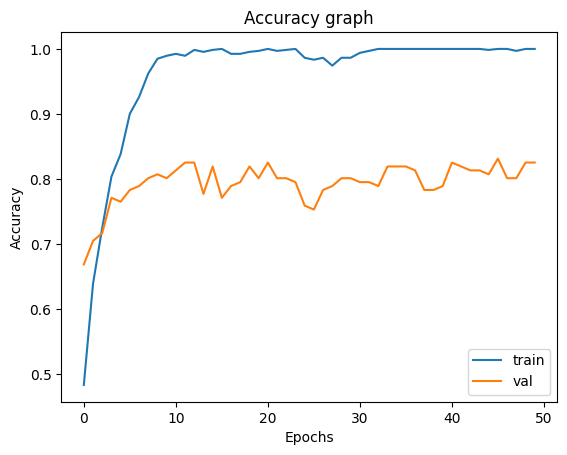

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

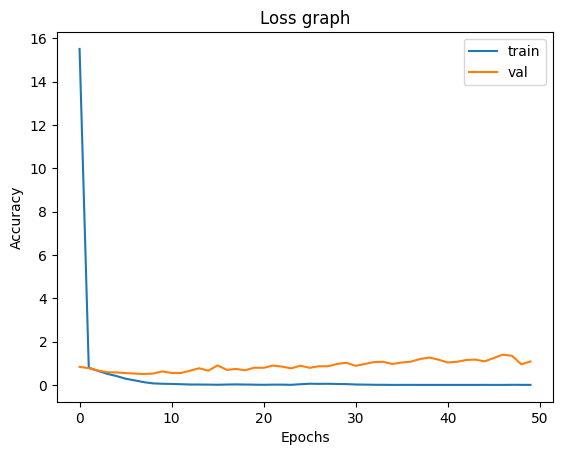

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.show()

In [32]:
model.save('audio_conv2d.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
